In [1]:
using Distributions
using FastGaussQuadrature
using Interpolations
using Plots
using Random
using Trapz

# Many Periods

## One Bidder - Value Function

In [2]:
function invhaz(D,x)
    return (1-cdf(D,x))/pdf(D,x)
end

function value_functions(θ0,θ_grid,T,γ,δ,G,H,M)
    # setup
    α, ω = gausshermite(M)
    θ_min = minimum(θ_grid)
    θ_max = maximum(θ_grid)
    θ_size = length(θ_grid)
    V_grid = zeros(T,length(θ_grid))
    ψ0 = invhaz(G,θ0)
    
    # value function for time T
    for i in 1:θ_size
        sell_value = θ_grid[i]-ψ0*γ^T
        V_grid[T,i] = max(sell_value,0)
    end
    
    # value functions for times 1 through T-1
    for t in T-1:-1:1
        Li = interpolate((θ_grid,),V_grid[t+1,:],Gridded(Linear()))
        Le = extrapolate(Li,Line())
        for i in 1:θ_size
            sell_value = θ_grid[i]-ψ0*γ^t
            wait_value = 0
            for k in 1:M
                y = γ*θ_grid[i]+sqrt(2)*std(H)*α[k]
                if (y >= θ_min && y <= θ_max)
                    wait_value = wait_value+ω[k]*Li(y)
                else
                    wait_value = wait_value+ω[k]*Le(y)
                end
            end
            wait_value = δ*wait_value/sqrt(π)
            V_grid[t,i] = max(sell_value,wait_value)
        end
    end
    
    # value function for time 0
    Li = interpolate((θ_grid,),V_grid[1,:],Gridded(Linear()))
    Le = extrapolate(Li,Line())
    sell_value = θ0-ψ0
    wait_value = 0
    for k in 1:M
        y = γ*θ0+sqrt(2)*std(H)*α[k]
        if (y >= θ_min && y <= θ_max)
            wait_value = wait_value+ω[k]*Li(y)
        else
            wait_value = wait_value+ω[k]*Le(y)
        end
    end
    wait_value = δ*wait_value/sqrt(π)

    V0 = max(sell_value,wait_value)
    
    # return
    return V0, V_grid
end

function value_function(θ0_grid,θ_grid,T,γ,δ,G,H,M)
    # setup
    θ0_size = length(θ0_grid)
    V0_grid = zeros(θ0_size)
    
    # value function at each grid point
    for i in 1:θ0_size
        V0, V_grid = value_functions(θ0_grid[i],θ_grid,T,γ,δ,G,H,M)
        V0_grid[i] = V0
    end
    
    # expected value
    EV = trapz(θ0_grid,V0_grid.*pdf(G,θ0_grid))
    
    # return
    return EV, V0_grid
end

value_function (generic function with 1 method)

In [3]:
θ_grid = LinRange(0.0,2.0,201)
θ0_grid = LinRange(0.0,2.0,201)

T = 1

γ = 0.9
δ = 0.95

G = Normal(1.0,0.2)
H = Normal(0.0,0.2)

M = 21

21

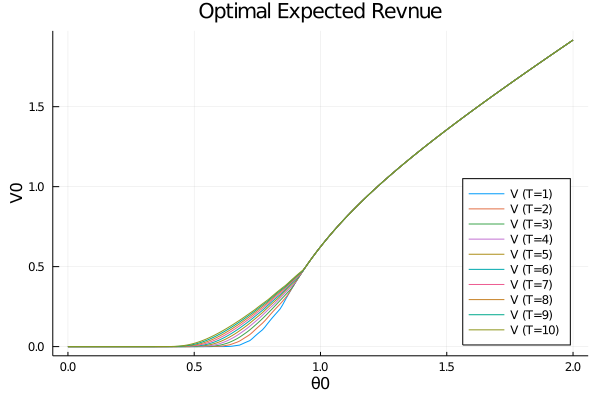

In [4]:
θ_grid = LinRange(-2.0,4.0,601)
θ0_grid = LinRange(0.0,2.0,201)

γ = 0.9
δ = 0.95

G = Normal(1.0,0.3)
H = Normal(0.0,0.3)

M = 21

T_grid = collect(1:10)
EV_grid = zeros(length(T_grid))
plot(title="Optimal Expected Revnue",xlab="θ0",ylab="V0",legend=:bottomright)
for i in 1:length(T_grid)
    EV, V0_grid = value_function(θ0_grid,θ_grid,T_grid[i],γ,δ,G,H,M)
    EV_grid[i] = EV
    plot!(θ0_grid,V0_grid,label="V (T=$(i))")
end
plot!()
# savefig("C:/Users/zhubr/Desktop/ECON 417/project/figures/N1TMval.png")

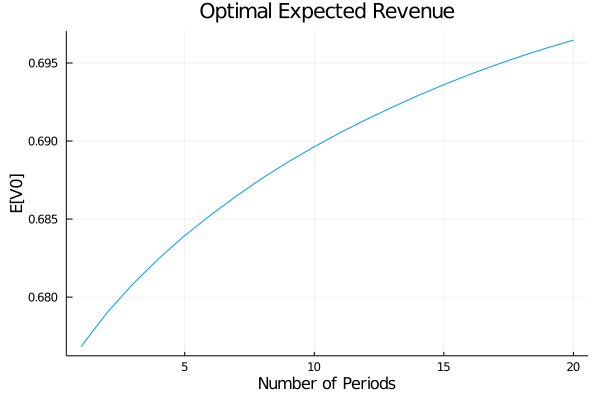

In [5]:
θ_grid = LinRange(-2.0,4.0,601)
θ0_grid = LinRange(0.0,2.0,201)

γ = 0.9
δ = 0.95

G = Normal(1.0,0.2)
H = Normal(0.0,0.2)

M = 21

T_grid = collect(1:20)
EV1_grid = zeros(length(T_grid))
for i in 1:length(T_grid)
    EV, V0_grid = value_function(θ0_grid,θ_grid,T_grid[i],γ,δ,G,H,M)
    EV1_grid[i] = EV
end
plot(T_grid,EV1_grid,title="Optimal Expected Revenue",xlab="Number of Periods",ylab="E[V0]",legend=:false)
# savefig("C:/Users/zhubr/Desktop/ECON 417/project/figures/N1TM.png")

## One Bidder - Simulate Auction

In [6]:
function simulate_auction(n_sims,θ_grid,T,γ,δ,G,H,M)
    sell_times = zeros(n_sims)
    sell_values = zeros(n_sims)
    θ_min = minimum(θ_grid)
    θ_max = maximum(θ_grid)
    for i in 1:n_sims
        θ0 = rand(G,1)[1]
        ψ0 = invhaz(G,θ0)
        α, ω = gausshermite(M)
        V0, V_grid = value_functions(θ0,θ_grid,T,γ,δ,G,H,M)
        θ0_curr = θ0
        for t in 0:T-1
            sell_value = δ^t*(θ0_curr-ψ0*γ^t)
            wait_value = 0
            Li = interpolate((θ_grid,),V_grid[t+1,:],Gridded(Linear()))
            Le = extrapolate(Li,Line())
            for k in 1:M
                y = γ*θ0_curr+sqrt(2)*std(H)*x[k]
                if (y >= θ_min && y <= θ_max)
                    wait_value = wait_value+w[k]*Li(y)
                else
                    wait_value = wait_value+w[k]*Le(y)
                end
            end
            wait_value = δ^t*wait_value/sqrt(π)
            if (sell_value > wait_value)
                sell_times[i] = t
                sell_values[i] = sell_value
                break
            else
                θ0_curr = γ*θ0_curr+rand(H,1)[1]
                if (t == T-1)
                    sell_values[i] = max(δ^T*(θ0_curr-ψ0*γ^T),0)
                    if (sell_values[i] == 0)
                        sell_times[i] = -1
                    else
                        sell_times[i] = T
                    end
                end
            end
        end
    end
    
    return sell_times, sell_values
end

simulate_auction (generic function with 1 method)

In [7]:
# n_sims = 1000000
# sell_times, sell_values = simulate_auction(n_sims,θ_grid,T,γ,δ,G,H,M)

# print(mean(sell_values),"\n")
# print(sum(sell_times)/n_sims)
# histogram(sell_values)

## Two Bidders - Value Function

In [8]:
function invhaz_multi(D,x)
    n = length(x)
    ih = zeros(n)
    for i in 1:n
        ih[i] = invhaz(D[i],x[i])
    end
    return ih
end

function value_functions_two(θ0,θ1_grid,θ2_grid,T,γ,δ,G,H,M)
    # setup
    α, ω = gausshermite(M)
    θ1_min = minimum(θ1_grid)
    θ1_max = maximum(θ1_grid)
    θ1_size = length(θ1_grid)
    θ2_min = minimum(θ2_grid)
    θ2_max = maximum(θ2_grid)
    θ2_size = length(θ2_grid)
    V_grid = zeros(T,length(θ1_grid),length(θ2_grid))
    ψ0 = invhaz_multi(G,θ0)
    
    # value function for time T
    for i in 1:θ1_size
        for j in 1:θ2_size
            sell_value = maximum([θ1_grid[i],θ2_grid[j]].-ψ0*γ^T)
            value = max(sell_value,0)
            V_grid[T,i,j] = value
        end
    end
    
    # value functions for times 1 through T-1
    for t in T-1:-1:1
        Li = interpolate((θ1_grid,θ2_grid),V_grid[t+1,:,:],Gridded(Linear()))
        Le = extrapolate(Li,Line())
        for i in 1:θ1_size
            for j in 1:θ2_size
                sell_value = maximum([θ1_grid[i],θ2_grid[j]].-ψ0*γ^t)
                wait_value = 0
                for k in 1:M
                    for l in 1:M
                        y1 = γ*θ1_grid[i]+sqrt(2)*std(H[1])*α[k]
                        y2 = γ*θ2_grid[j]+sqrt(2)*std(H[2])*α[l]
                        if (y1 >= θ1_min && y1 <= θ1_max && y2 >= θ2_min && y2 <= θ2_max)
                            wait_value = wait_value+ω[k]*ω[l]*Li(y1,y2)
                        else
                            wait_value = wait_value+ω[k]*ω[l]*Le(y1,y2)
                        end
                    end
                end
                wait_value = δ*wait_value/π
                V_grid[t,i,j] = max(sell_value,wait_value)
            end
        end
    end
    
    # value function for time 0
    Li = interpolate((θ1_grid,θ2_grid,),V_grid[1,:,:],Gridded(Linear()))
    Le = extrapolate(Li,Line())
    sell_value = maximum(θ0.-ψ0)
    wait_value = 0
    for k in 1:M
        for l in 1:M
            y1 = γ*θ0[1]+sqrt(2)*std(H[1])*α[k]
            y2 = γ*θ0[2]+sqrt(2)*std(H[2])*α[l]
            if (y1 >= θ1_min && y1 <= θ1_max && y2 >= θ2_min && y2 <= θ2_max)
                wait_value = wait_value+ω[k]*ω[l]*Li(y1,y2)
            else
                wait_value = wait_value+ω[k]*ω[l]*Le(y1,y2)
            end
        end
    end
    wait_value = δ*wait_value/π
    V0 = max(sell_value,wait_value)
    
    # return
    return V0, V_grid
end

function value_function_two(θ0_1_grid,θ0_2_grid,θ1_grid,θ2_grid,T,γ,δ,G,H,M)
    # setup
    θ0_1_size = length(θ0_1_grid)
    θ0_2_size = length(θ0_2_grid)
    V0_grid = zeros(θ0_1_size,θ0_2_size)
    M0_grid = zeros(θ0_1_size,θ0_2_size)
    
    # value function at each grid point
    for i in 1:θ0_1_size
        for j in 1:θ0_2_size
            V0, V_grid = value_functions_two([θ0_1_grid[i],θ0_2_grid[j]],θ1_grid,θ2_grid,T,γ,δ,G,H,M)
            V0_grid[i,j] = V0
            M0_grid[i,j] = V0*pdf(G[1],θ0_1_grid[i])*pdf(G[2],θ0_2_grid[j])
        end
    end
    
    # expected value
    EV = trapz((θ0_1_grid,θ0_2_grid),M0_grid)
    
    # return
    return EV, V0_grid
end

value_function_two (generic function with 1 method)

In [9]:
θ1_grid = LinRange(0.0,2.0,21)
θ2_grid = LinRange(0.0,2.0,21)

# θ0_1_grid = LinRange(0.0,2.0,201)
# θ0_2_grid = LinRange(0.0,2.0,201)

θ0_1_grid = LinRange(-1.0,3.0,201)
θ0_2_grid = LinRange(-1.0,3.0,201)

T = 4

γ = 0.9
δ = 0.95

G1 = Normal(1.0,0.3)
G2 = Normal(1.0,0.3)
H1 = Normal(0.0,0.3)
H2 = Normal(0.0,0.3)
G = [G1,G2]
H = [H1,H2]

M = 5

5

In [10]:
θ1_grid = LinRange(0.0,2.0,21)
θ2_grid = LinRange(0.0,2.0,21)

θ0_1_grid = LinRange(-1.0,3.0,201)
θ0_2_grid = LinRange(-1.0,3.0,201)

γ = 0.9
δ = 0.95

G1 = Normal(1.0,0.2)
G2 = Normal(1.0,0.2)
H1 = Normal(0.0,0.2)
H2 = Normal(0.0,0.2)
G = [G1,G2]
H = [H1,H2]

M = 5

5

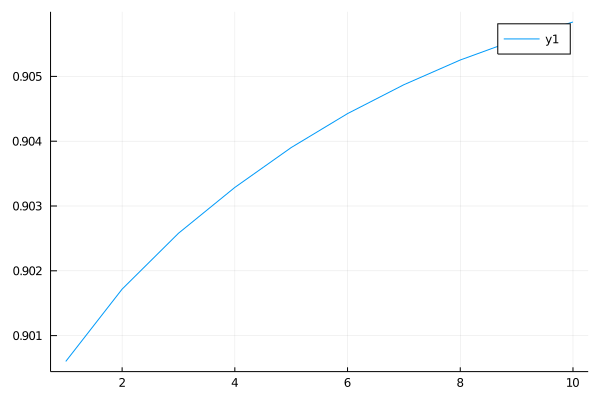

In [11]:
T_grid = collect(1:10)
EV2_grid = zeros(length(T_grid))
for i in 1:length(T_grid)
    EV, V0_grid = value_function_two(θ0_1_grid,θ0_2_grid,θ1_grid,θ2_grid,T_grid[i],γ,δ,G,H,M)
    EV2_grid[i] = EV
end
plot(T_grid,EV2_grid)

## Two Bidders - Simulate Auction

In [12]:
function simulate_auction_two(n_sims,θ1_grid,θ2_grid,T,γ,δ,G,H,M)
    sell_times = zeros(n_sims)
    sell_values = zeros(n_sims)
    sell_agents = zeros(n_sims)
    θ1_min = minimum(θ1_grid)
    θ1_max = maximum(θ1_grid)
    θ2_min = minimum(θ2_grid)
    θ2_max = maximum(θ2_grid)
    for i in 1:n_sims
        θ0 = [rand(G[1],1)[1],rand(G[2],1)[1]]
        ψ0 = invhaz_multi(G,θ0)
        α, ω = gausshermite(M)
        V0, V_grid = value_functions_two(θ0,θ1_grid,θ2_grid,T,γ,δ,G,H,M)
        θ0_curr = θ0
        for t in 0:T-1
            sell_value = maximum(δ^t*(θ0_curr.-ψ0*γ^t))
            sell_agent = argmax(δ^t*(θ0_curr.-ψ0*γ^t))
            wait_value = 0
            Li = interpolate((θ1_grid,θ2_grid),V_grid[t+1,:,:],Gridded(Linear()))
            Le = extrapolate(Li,Line())
            for k in 1:M
                for l in 1:M
                    y1 = γ*θ0_curr[1]+sqrt(2)*std(H[1])*α[k]
                    y2 = γ*θ0_curr[1]+sqrt(2)*std(H[2])*α[l]
                    if (y1 >= θ1_min && y1 <= θ1_max && y2 >= θ2_min && y2 <= θ2_max)
                        wait_value = wait_value+ω[k]*ω[l]*Li(y1,y2)
                    else
                        wait_value = wait_value+ω[k]*ω[l]*Le(y1,y2)
                    end
                end
            end
            wait_value = δ^t*wait_value/π
            if (sell_value > wait_value)
                sell_times[i] = t
                sell_values[i] = sell_value
                sell_agents[i] = sell_agent
                break
            else
                θ0_curr = γ*θ0_curr.+[rand(H[1],1)[1],rand(H[2],1)[1]]
                if (t==T-1)
                    sell_values[i] = max(maximum(δ^T*(θ0_curr.-ψ0*γ^T)),0)
                    if (sell_values[i] == 0)
                        sell_times[i] = -1
                        sell_agents[i] = -1
                    else
                        sell_times[i] = T
                        sell_agents[i] = argmax(δ^T*(θ0_curr-ψ0*γ^T))
                    end
                end
            end
        end
    end
    return sell_times, sell_values, sell_agents
end

simulate_auction_two (generic function with 1 method)

In [13]:
# n_sims = 1000000
# sell_times, sell_values, sell_agents = simulate_auction_two(n_sims,θ1_grid,θ2_grid,T,γ,δ,G,H,M)
# print(mean(sell_values))
# histogram(sell_values)

## Many Bidders - Value Function

In [14]:
function sim_type_path(N,T,γ,δ,G,H,M)
    path = zeros(N,T+1)
    for i in 1:N
        path[i,1] = rand(G[i],1)[1]
        for t in 2:T+1
            path[i,t] = γ*path[i,t-1]+rand(H[i],1)[1]
        end
    end
    return path
end

sim_type_path (generic function with 1 method)

In [15]:
function ER_many(N,T,γ,δ,G,H,M;n_sims=1000000)
    opt_rev = zeros(n_sims)
    for k in 1:n_sims
        path = sim_type_path(N,T,γ,δ,G,H,M)
        rev = zeros(N,T+1)
        for i in 1:N
            θ0 = path[i,1]
            ψ0 = (1-cdf(G[i],θ0))/pdf(G[i],θ0)
            for t in 1:T+1     
                rev[i,t] = δ^(t-1)*(path[i,t]-ψ0*γ^(t-1))
            end
        end
        opt_rev[k] = max(maximum(rev),0)
    end
    # display(histogram(opt_rev,bins=50))
    return(mean(opt_rev))
end

ER_many (generic function with 1 method)

In [16]:
N = 7
T = 2

γ = 0.9
δ = 0.95

G = Array{Normal{Float64}}(undef,N)
H = Array{Normal{Float64}}(undef,N)
for i in 1:N
    G[i] = Normal(1.0,0.2)
    H[i] = Normal(0.0,0.2)
end

M = 5
n_sims = 10000

10000

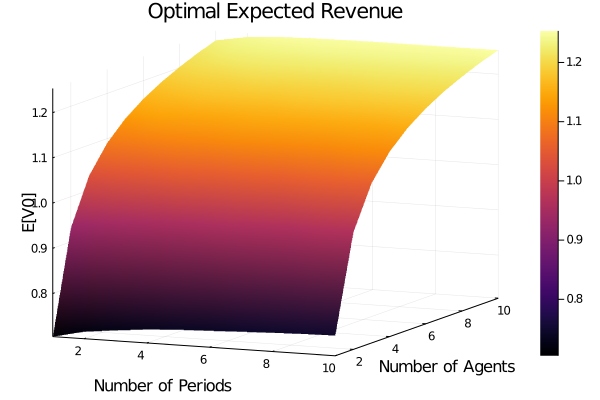

In [17]:
N_grid = collect(1:10)
T_grid = collect(1:10)
EV_grid = zeros(length(N_grid),length(T_grid))
for i in 1:length(N_grid)
    for t in 1:length(T_grid)
        G = Array{Normal{Float64}}(undef,N_grid[i])
        H = Array{Normal{Float64}}(undef,N_grid[i])
        for i in 1:N_grid[i]
            G[i] = Normal(1.0,0.2)
            H[i] = Normal(0.0,0.2)
        end
        EV_grid[i,t] = ER_many(N_grid[i],T_grid[t],γ,δ,G,H,M)
        # print(i," ",t,"\n")
    end
end
plot(N_grid,T_grid,EV_grid,st=:surface,title="Optimal Expected Revenue",
     xlab="Number of Periods",ylab="Number of Agents",zlab="E[V0]")
# savefig("C:/Users/zhubr/Desktop/ECON 417/project/figures/NMTM.png")

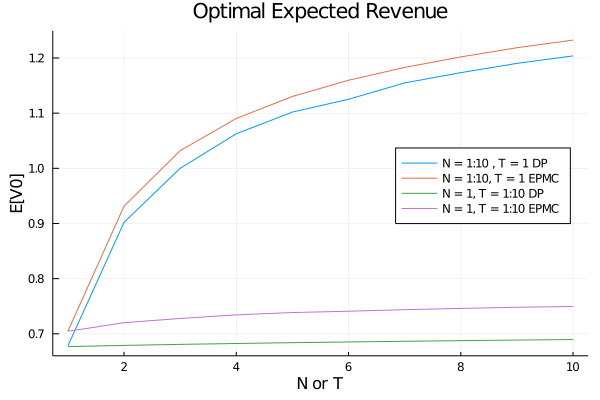

In [18]:
EVn_grid = [0.6781444461805215,0.9021316770017797,1.0000546945631097,1.0627147872787504,1.1019796286084114,
            1.125245416021177,1.154846632648926,1.1734688475147508,1.190250392113218,1.2038065890891927]

NMTM1 = plot(N_grid,EVn_grid,label="N = 1:10 , T = 1 DP",legend=:right,title="Optimal Expected Revenue",
     xlab="N or T",ylab="E[V0]")
NMTM1 = plot!(N_grid,EV_grid[:,1],label="N = 1:10, T = 1 EPMC")
NMTM1 = plot!(T_grid,EV1_grid[1:10],label="N = 1, T = 1:10 DP")
NMTM1 = plot!(T_grid,EV_grid[1,:],label="N = 1, T = 1:10 EPMC")

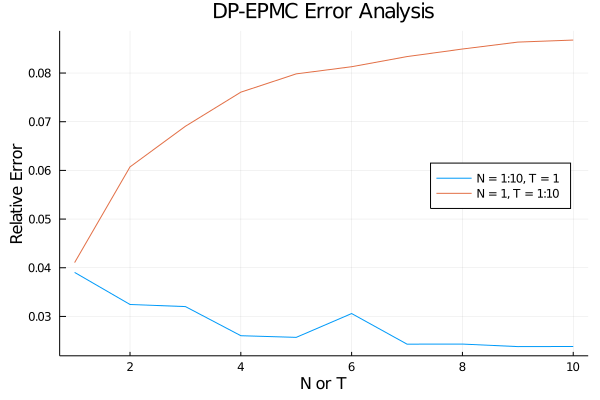

In [19]:
NMTM2 = plot(N_grid,(EV_grid[:,1].-EVn_grid)./EVn_grid,title="DP-EPMC Error Analysis",xlab="N or T",ylab="Relative Error",
     label="N = 1:10, T = 1",legend=:right)
NMTM2 = plot!(T_grid,(EV_grid[1,:].-EV1_grid[1:10])./EV1_grid[1:10],label="N = 1, T = 1:10")

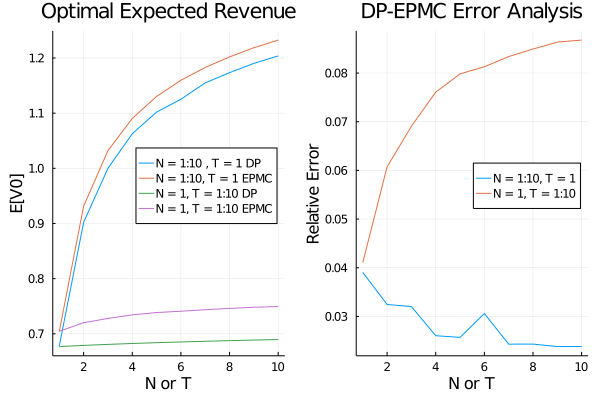

In [20]:
l = @layout [ a b ]
plot(NMTM1,NMTM2,layout=l)
# savefig("C:/Users/zhubr/Desktop/ECON 417/project/figures/NMTMcs.png")